<a href="https://colab.research.google.com/github/ShashankS1ngh/ML/blob/main/Titanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import  absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import seaborn as sb
from tensorflow import keras as ks
from tensorflow.estimator import LinearRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
Titanic_load=pd.read_csv("https://raw.githubusercontent.com/ShashankS1ngh/ML/main/DATASETS/train.csv")

In [ ]:
Titanic_load.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
feature_columns=Titanic_load.columns
target_columns=Titanic_load['Survived']

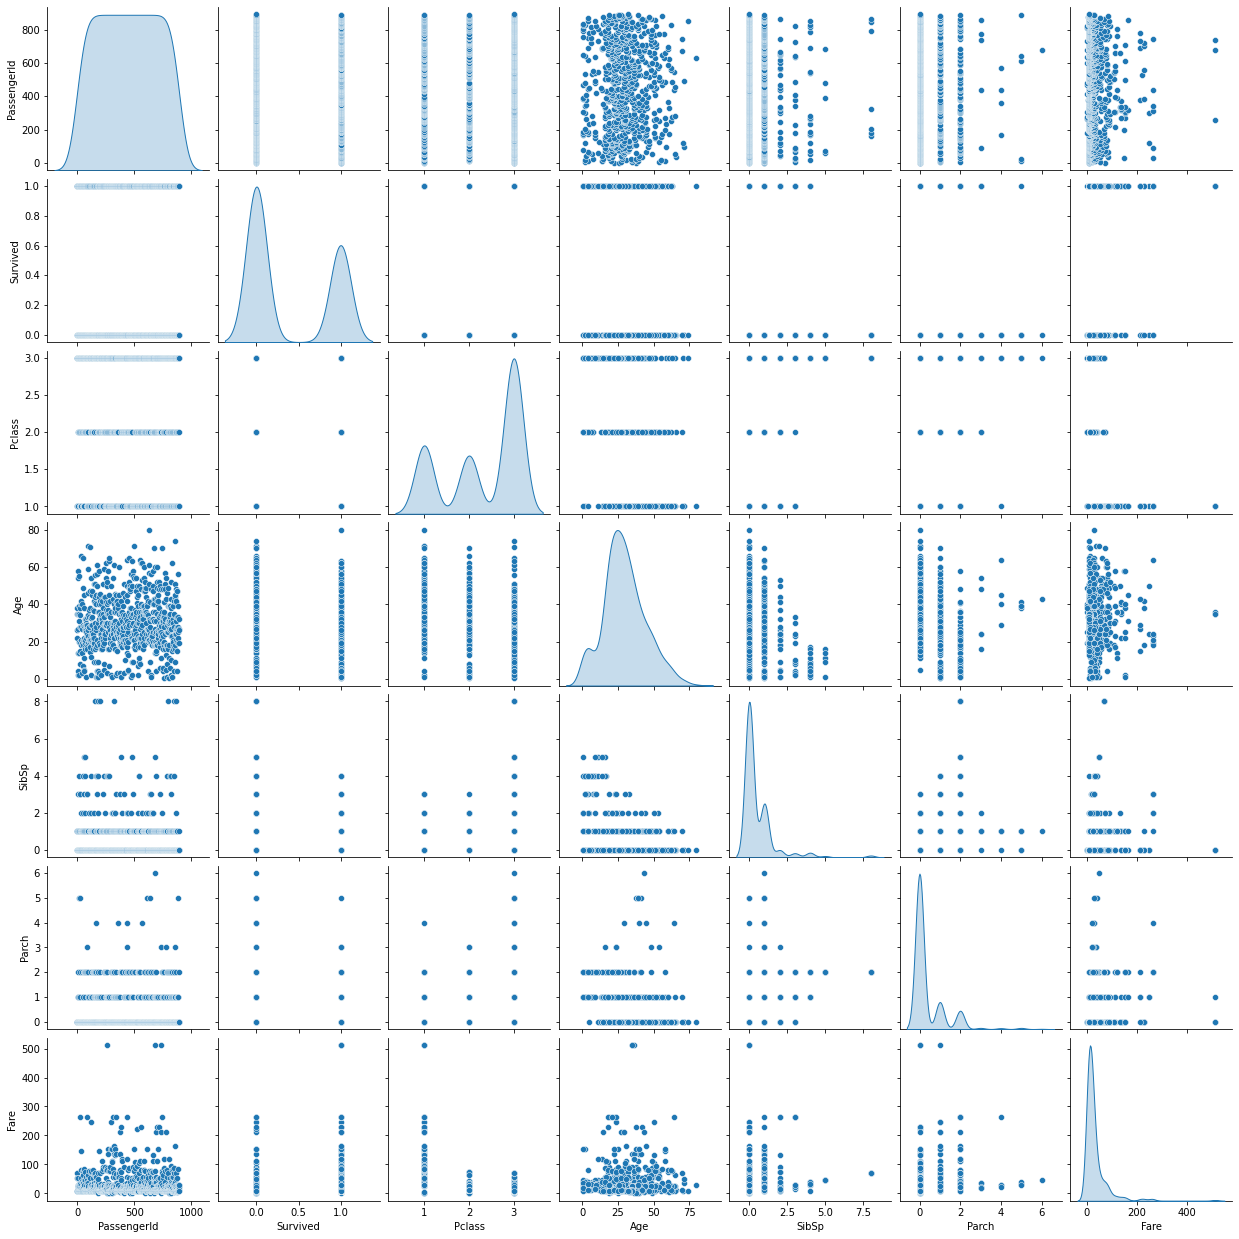

In [ ]:
sb.pairplot(Titanic_load, diag_kind="kde")

In [ ]:
correlation_data=Titanic_load.corr()
correlation_data.style.background_gradient(cmap='coolwarm',axis=None)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [ ]:
X_data=Titanic_load[[i for i in Titanic_load.columns if i not in ['Survived']]]
Y_data=Titanic_load[['Survived']]

In [ ]:
training_features , test_features , training_labels, test_labels= train_test_split(X_data,Y_data,test_size=0.2)

In [ ]:
def norm(x):
  stats= x.describe()
  stats= stats.transpose()
  return(x-stats['mean'])/stats['std']
normed_train_features= norm(training_features)
normed_test_features= norm(test_features)

In [ ]:
X_test_imputed=test_features

In [ ]:
X_train_imputed=training_features

**Pipeline**

In [ ]:
def feed_input(features_dataframe, target_dataframe,num_of_epochs=10,shuffle=True, batch_size=32):
  def input_feed_function():
    dataset= tf.data.Dataset.from_tensor_slices((dict(features_dataframe),target_dataframe))
    if shuffle:
      dataset= dataset.shuffle(2000)
      dataset=dataset.batch(batch_size).repeat(num_of_epochs)
    return dataset
  return input_feed_function    

In [ ]:
train_feed_input= feed_input(normed_train_features,training_labels)
train_feed_input_testing= feed_input(normed_train_features,training_labels, num_of_epochs=1,shuffle=False)


In [ ]:
#feature_columns_numeric=[tf.feature_column.numeric_column(m) for m in training_features.columns]
#linear_model= LinearRegressor(feature_columns=feature_columns_numeric,optimizer="RMSProp")
#linear_model.train(train_feed_input)

In [ ]:
normed_train_features.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Ticket'],
      dtype='object')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
num_pipeline.fit_transform(X_train_imputed)

array([[28.    ,  0.    ,  0.    , 26.    ],
       [24.    ,  0.    ,  0.    ,  7.4958],
       [ 9.    ,  1.    ,  1.    , 15.9   ],
       ...,
       [28.    ,  8.    ,  2.    , 69.55  ],
       [28.    ,  1.    ,  0.    , 82.1708],
       [28.    ,  0.    ,  0.    , 35.5   ]])

In [ ]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(X_train_imputed)

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
X_check_train=preprocess_pipeline.fit_transform(X_train_imputed)
X_check_test=preprocess_pipeline.fit_transform(X_test_imputed)

In [ ]:
X_train_data=pd.DataFrame(X_check_train,columns=feature_columns).astype(np.float32)
X_test_data=pd.DataFrame(X_check_test,columns=feature_columns).astype(np.float32)

In [ ]:
final_train=norm(X_train_data)
final_test=norm(X_test_data)


In [ ]:
train_feed_input_check= feed_input(final_train ,training_labels)
train_feed_input_testing_check= feed_input(final_train,training_labels, num_of_epochs=1,shuffle=False)
test_feed_input_check=feed_input(final_test, test_labels,num_of_epochs=1, shuffle=False)

In [ ]:
feature_columns_numeric_check=[tf.feature_column.numeric_column(m) for m in training_features.columns]
linear_model= LinearRegressor(feature_columns=feature_columns_numeric,optimizer="RMSProp")
linear_model.train(train_feed_input_check)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9x5zgoom', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9x5zgoom/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.28125, step = 0
INFO:tensorflow:global_step/sec: 441.706
INFO:tensorflow:loss = 0.1631594, step = 100 (0.230 sec)
INFO:tensorflow:global_step/sec: 789.241
INFO:tensorflow:loss = 0.3004972, step = 200 (0.124 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230...
INFO:tensorflow:Saving checkpoints for 230 into /tmp/tmp9x5zgoom/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230...
INFO:tensorflow:Loss for final step: 1.8118117.


In [ ]:
train_predictions_check= linear_model.predict(train_feed_input_testing_check)
test_predictions_check= linear_model.predict(test_feed_input_check)
train_predictions_series= pd.Series([p['predictions'][0]for p in train_predictions_check])

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


ValueError: ignored